In this project we develop a model that recognizes a 28 by 28 image of a digit using deep learning. We also develop an interface where users can draw their own images in order to apply the model. 

# Set up

To set up, you simply need to make sure the following libraries have been installed. 

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pygame
from pygame.locals import *
import matplotlib.pyplot as plt

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Aquiring Data

To get training data, we can simply use the mnist dataset that keras provides. We also proccess the data to make it compatible with our model. 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Model Creation

Now we create the model using Keras's functional API

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


# Training The Model

To train the model we just need to specify a few important values and then we can procceed. 

In [4]:
model.compile(optimizer = 'rmsprop', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [5]:
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=7)

Epoch 1/7
750/750 [==============================] - 4s 4ms/step - loss: 0.5655 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.1852 - val_sparse_categorical_accuracy: 0.9449
Epoch 2/7
750/750 [==============================] - 2s 3ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1354 - val_sparse_categorical_accuracy: 0.9597
Epoch 3/7
750/750 [==============================] - 2s 3ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.1130 - val_sparse_categorical_accuracy: 0.9677
Epoch 4/7
750/750 [==============================] - 2s 3ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.1125 - val_sparse_categorical_accuracy: 0.9663
Epoch 5/7
750/750 [==============================] - 2s 3ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.1215 - val_sparse_categorical_accuracy: 0.9673
Epoch 6/7
750/750 [==============================] - 2s 3ms/step - loss: 0.0634 - sparse_categorical_accu

# Using the model

To allow the user to draw their own digits, we use the pygame library. Running the second cell will pop up a window where one can draw their number. To draw just hold down and drag the mouse. To finish drawing the image and exit the window, simply press the space key. Running the third cell displays the model's prediction and what probabilities it assigned to the other numbers. 

In [6]:
import pygame 
from pygame.locals import *

class canvas:
    def __init__(self, pixels, topleft, size = 28):
        self.size = size
        self.pixels = pixels
        self.topleft = topleft
        self.colors = [[0 for i in range(size)] for i in range(size)]
        self.all_pixels = [[pygame.Rect(topleft[0]+i, topleft[1]+j, pixels, pixels) for i in range(0,size*pixels,pixels)]
                        for j in range(0,size*pixels,pixels)]
        self.pixel_locked = (0,0)

    def show(self, gd):
        for row_rect, row_color in zip(self.all_pixels, self.colors):
            for rect, color in zip(row_rect, row_color):
                pygame.draw.rect(gd, (color,color,color), rect)
        
        x,y = self.topleft[0], self.topleft[1]
        for i in range(0, self.size*self.pixels+1, self.pixels):
            pygame.draw.line(gameDisplay, (255,255,255), (x, y+i), (x+self.size*self.pixels, y+i))
            pygame.draw.line(gameDisplay, (255,255,255), (y+i, y), (i+x, y+self.size*self.pixels))
                
    def draw(self, mouse_coor):
        x_index, y_index = (int((coor-start)/self.pixels) for coor, start in zip(mouse_coor, self.topleft))
        
        if (self.pixel_locked[0] == x_index and self.pixel_locked[1] == y_index): 
            pass
        elif x_index >= self.size or y_index >= self.size or x_index < 0 or y_index < 0:
            pass
        else:
            self.pixel_locked = (x_index, y_index)
            
            for i in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
                try:
                    if x_index+i[1] >= 0 and y_index + i[0] >= 0:
                        self.colors[y_index + i[0]][x_index+i[1]] = min(self.colors[y_index + i[0]][x_index+i[1]] + 64, 255)
                except IndexError:
                    pass
            for i in [(-1, 0), (0, -1), (1, 0), (0, 1)]:
                try:
                    if x_index+i[1] >= 0 and y_index + i[0] >= 0:
                        self.colors[y_index + i[0]][x_index+i[1]] = min(self.colors[y_index + i[0]][x_index+i[1]] + 128, 255)
                except IndexError:
                    pass
            self.colors[y_index][x_index] = 255

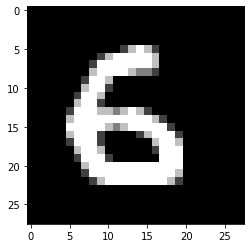

In [7]:
import pygame
from pygame.locals import *
import matplotlib.pyplot as plt

pygame.init()
pygame.display.set_caption("Draw Number")
gameDisplay = pygame.display.set_mode((500,500))
clock = pygame.time.Clock()
dcanvas = canvas(pixels = 10, topleft = (50,50))

run = True
track_pos = False
while run:
    
    for event in pygame.event.get():
        if event.type == QUIT:
            run = False
        elif event.type == KEYDOWN:
            if event.key == pygame.K_SPACE:
                run = False    
        elif event.type == MOUSEBUTTONDOWN:
            track_pos = True
        elif event.type == MOUSEBUTTONUP:
            track_pos = False
            
        if track_pos:
            if event.type == MOUSEMOTION:
                dcanvas.draw(event.pos)
        
    gameDisplay.fill((0,0,0))    
    dcanvas.show(gameDisplay)
    
    pygame.display.update()            
    clock.tick(60)


number = np.array(dcanvas.colors).reshape(1, 784) / 255
pygame.quit()
plt.imshow(np.array(dcanvas.colors), cmap='gray', vmin=0, vmax=255)

6


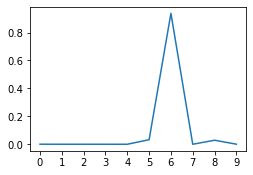

In [8]:
print(int(tf.argmax(model(number), axis = 1)))

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.5,0.5])
ax.plot(np.arange(10), tf.squeeze(model(number)))
j = ax.set_xticks([i for i in range(10)])